# Analysis

In [1]:
import pandas as pd
import plotnine as pn


In [2]:
# Load data

# Pareto frontier
curve_fn = "/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/curve_points.csv"

# Explored hypothetical systems
sampled_fn = "/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/sampled_points.csv"

# simulation points
alphas = [0, 2, 4, 6, 8, 10]

# Learned
# alpha_fns = {
#     f"{alpha}":f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics=reinforcement_learning/num_trials=10/sim_param={alpha}/simulation_points.csv"
#     for alpha in alphas
# }

# Evolved
alpha_fns = {
    f"{alpha}": f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics=replicator_dynamic/num_trials=10/sim_param={alpha}/simulation_points.csv"
    for alpha in alphas
}



In [3]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
sampled_data = pd.read_csv(sampled_fn)
simulation_dataframes = {
    k: pd.read_csv(alpha_fns[k]) for k in alpha_fns
}

In [4]:
# combine simulation dataframes
for key in simulation_dataframes:
    df = simulation_dataframes[key]
    df["alpha"] = key # use string for category

sim_data = pd.concat(simulation_dataframes.values())
sim_data

,rate,distortion,alpha
0,3.321928e+00,2.098427e-16,0
1,3.321926e+00,9.309179e-08,0
2,2.921928e+00,1.000000e+00,0
3,3.321921e+00,1.529188e-05,0
4,3.121928e+00,1.000000e-01,0
5,3.121928e+00,2.500000e+00,0
6,3.321928e+00,2.444640e-12,0
7,3.321921e+00,2.437997e-05,0
8,3.121928e+00,9.000000e-01,0
9,3.121928e+00,9.000000e-01,0


In [5]:
# plot each language, with a unique color for each gamma

# TODO: get beta-counterparts

sim_data = sim_data.assign(
        alpha=pd.Categorical(
            sim_data["alpha"], 
            categories=[g for g in simulation_dataframes.keys()]
        )
    )  # preserve order in legend

# sim_data["language"] = "learned"
sim_data["language"] = "evolved"
sampled_data["language"] = "hypothetical"


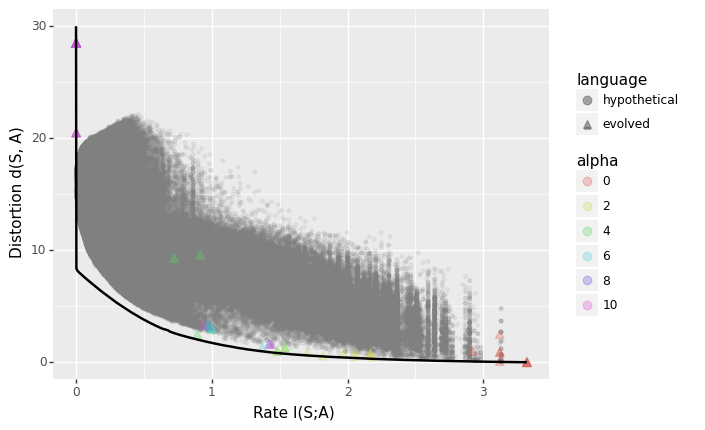

In [6]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # sampled langs
        sampled_data,
        pn.aes(shape="language"),
        color="gray",
        size=1,
        alpha=0.1,
    )        
    + pn.geom_jitter( # simulation langs
        data=sim_data,
        mapping=pn.aes(
            color="alpha", 
            shape="language",
            ),
        alpha=0.3,
        # shape="o",
        size=3,
        # height=0.1,
    )
    + pn.geom_line(size=1) # pareto data last    
    + pn.xlab("Rate I(S;A)")
    + pn.ylab("Distortion d(S, A)")
)
print(plot)

In [7]:
plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics={dynamic}/num_trials=10"
fn = plot_save_dir + "/multiple_alpha.png"
plot.save(filename=fn, width=10, height=10, dpi=300)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics=reinforcement_learning/num_trials=10/multiple_alpha.png
